# Lecture 24 Lab: Random Forests
## CMSE 381 - Fall 2022
## Nov 14, 2022

![](https://creazilla-store.fra1.digitaloceanspaces.com/cliparts/63890/forest-glade-clipart-md.png)

In this module we are going to set up random forest models.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Loading the data

Since we're doing regression trees, again, we're going to use the `Carseat` data where we will predict `Sales` from the rest of the columns. I'll do a bit of cleanup for you so we can get to the good stuff.

In [2]:
carseats = pd.read_csv('Carseats.csv').drop('Unnamed: 0', axis=1)
carseats.ShelveLoc = pd.factorize(carseats.ShelveLoc)[0]
carseats.Urban = carseats.Urban.map({'No':0, 'Yes':1})
carseats.US = carseats.US.map({'No':0, 'Yes':1})
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 34.5 KB


In [3]:
X = carseats.drop(['Sales'], axis = 1)
y = carseats.Sales
X.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,138,73,11,276,120,0,42,17,1,1
1,111,48,16,260,83,1,65,10,1,1
2,113,35,10,269,80,2,59,12,1,1
3,117,100,4,466,97,2,55,14,1,1
4,141,64,3,340,128,0,38,13,1,0


# Bagging 

Last time, we figured out how to use `sklearn.tree.DecisionTreeRegressor` to build a single tree to do our regression, but we'd like to be able to use ensemble models to create a pile of trees to give a more robust predction. 

Let's try doing this the hard way first. We're going to set up the bagging on our `carseats` data. We'll use $B=3$ to create our bagged model. So, step one is to generate three bootstrap samples, meaning I generate data sets by sampling $n=400$ points with replacement. 

In [4]:
X1 = carseats.sample(n = 400, replace = True, random_state = 42)
y1 = X1.Sales
X1 = X1.drop(['Sales'], axis = 1)

X2 = carseats.sample(n = 400, replace = True, random_state = 43)
y2 = X2.Sales
X2 = X2.drop(['Sales'], axis = 1)

X3 = carseats.sample(n = 400, replace = True, random_state = 44)
y3 = X3.Sales
X3 = X3.drop(['Sales'], axis = 1)


&#9989; **<font color=red>Do this:</font>** Fit one regression tree of depth 2 per sampled data we just created. You'll end up with three regression trees: call them `reg_tree1`, `reg_tree2`, and `reg_tree3`. How similar are the tree structures?

In [5]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [8]:
# Your code to generate the three trees here #
reg_tree1 = DecisionTreeRegressor(max_depth = 2)
reg_tree1.fit(X1,y1)
reg_tree2 = DecisionTreeRegressor(max_depth = 2)
reg_tree2.fit(X2,y2)
reg_tree3 = DecisionTreeRegressor(max_depth = 2)
reg_tree3.fit(X3,y3)

DecisionTreeRegressor(max_depth=2)

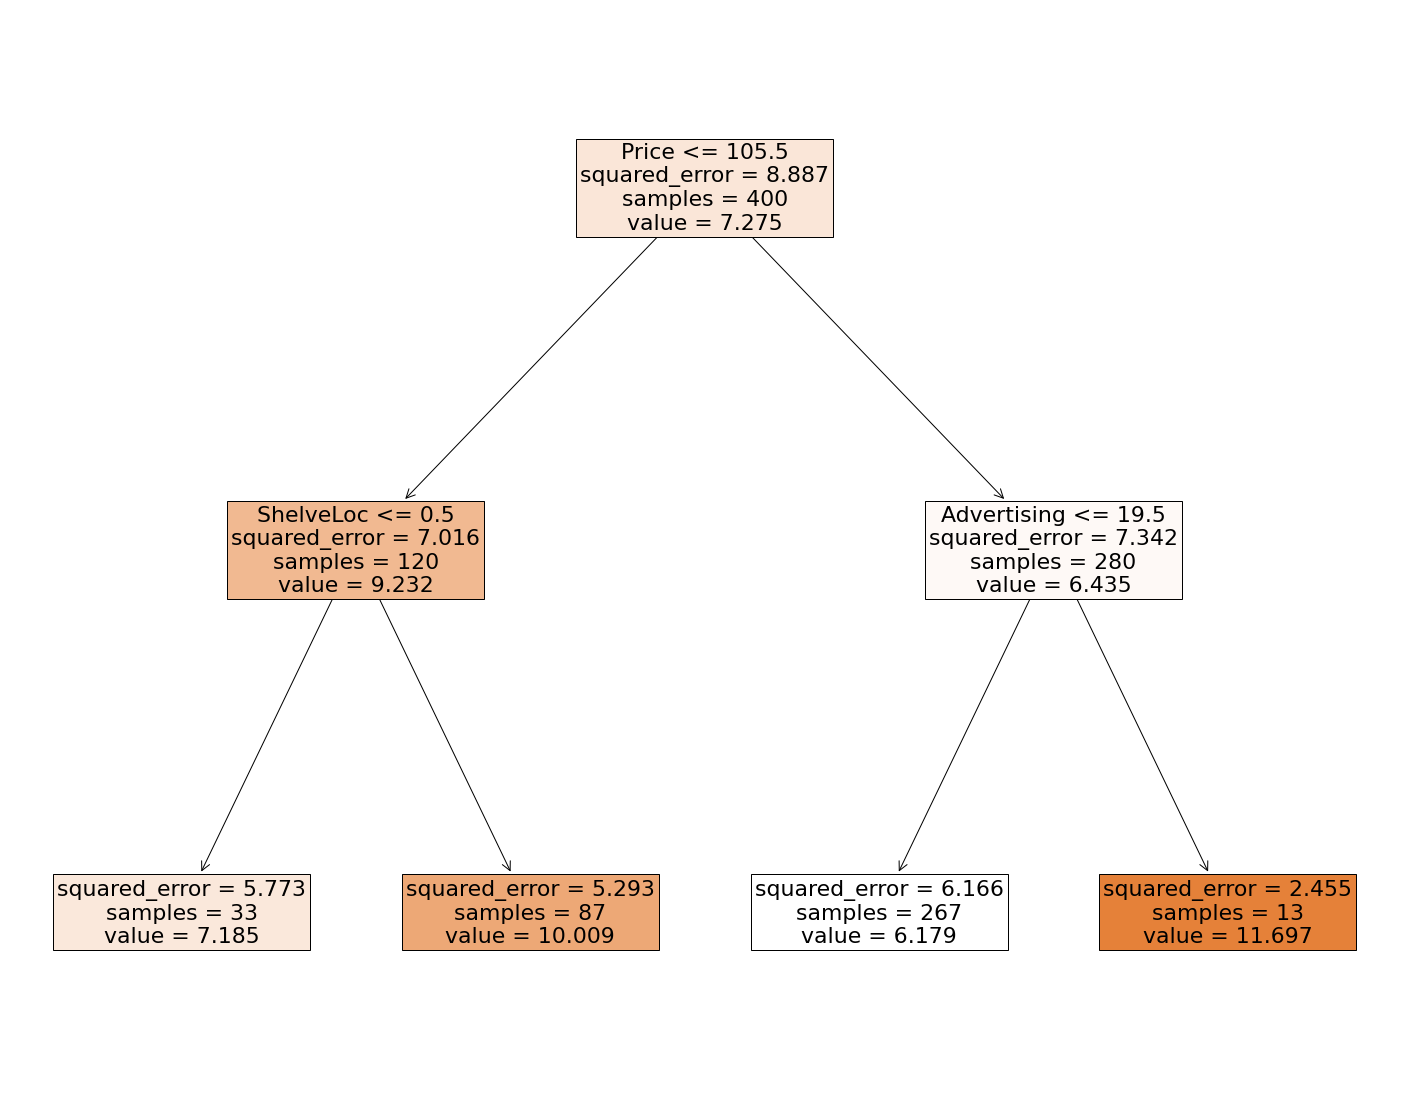

In [9]:
fig = plt.figure(figsize = (25,20))
_= tree.plot_tree(reg_tree1, feature_names = X.columns, 
               filled = True, 
              fontsize = 22)

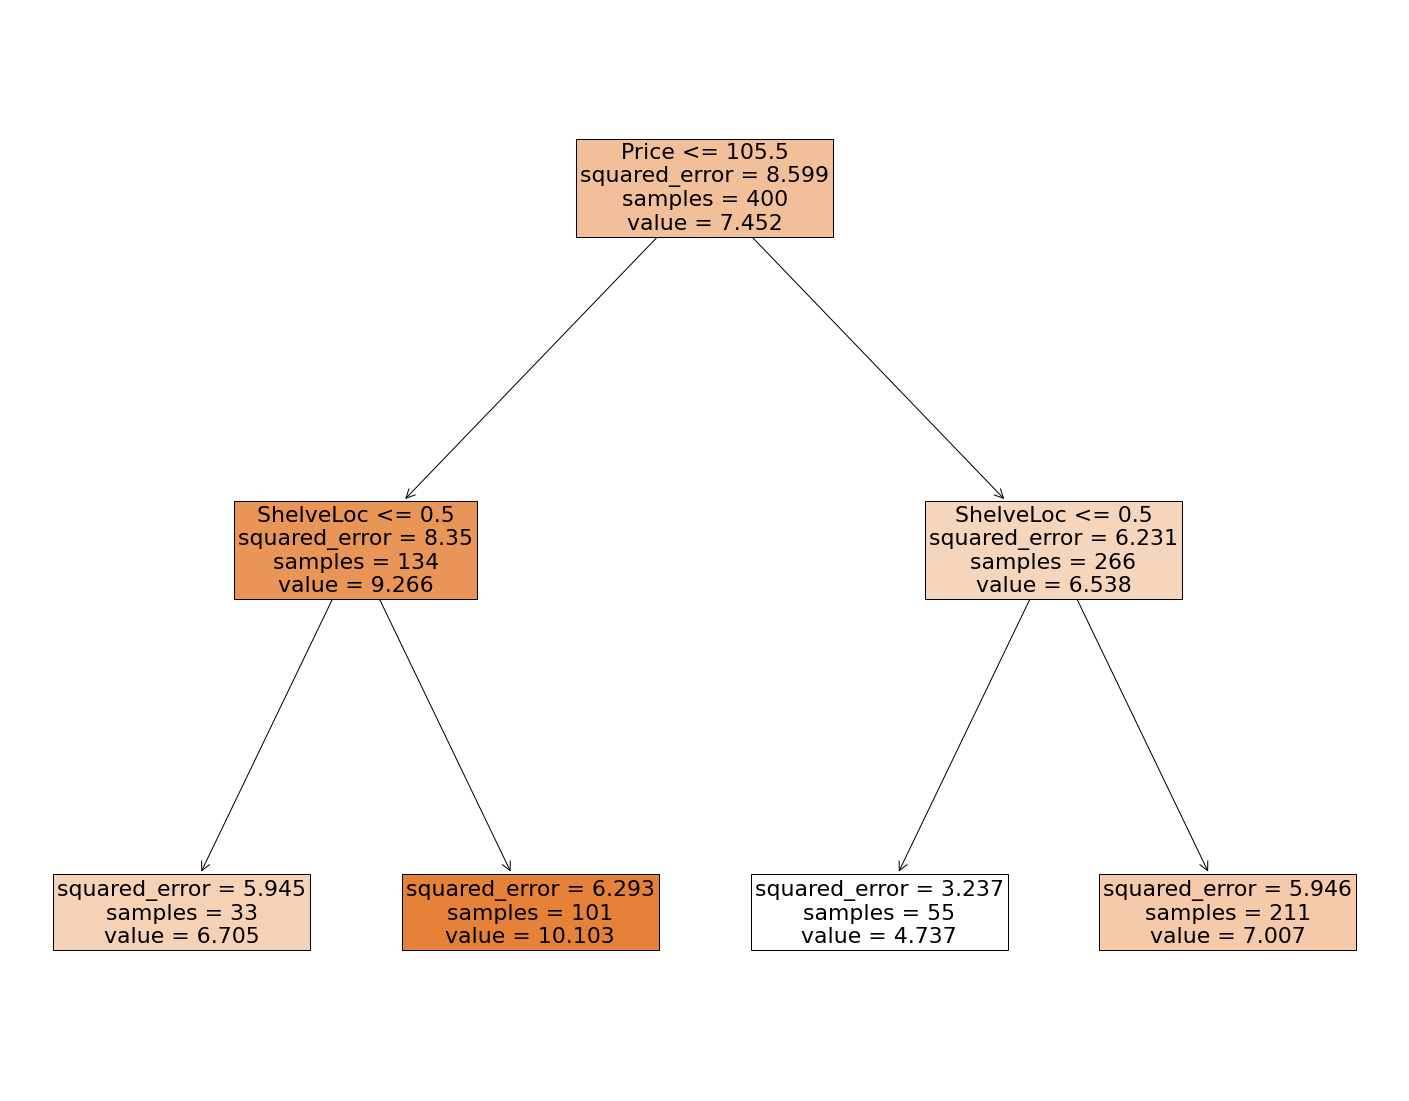

In [10]:
fig = plt.figure(figsize = (25,20))
_= tree.plot_tree(reg_tree2, feature_names = X.columns, 
               filled = True, 
              fontsize = 22)

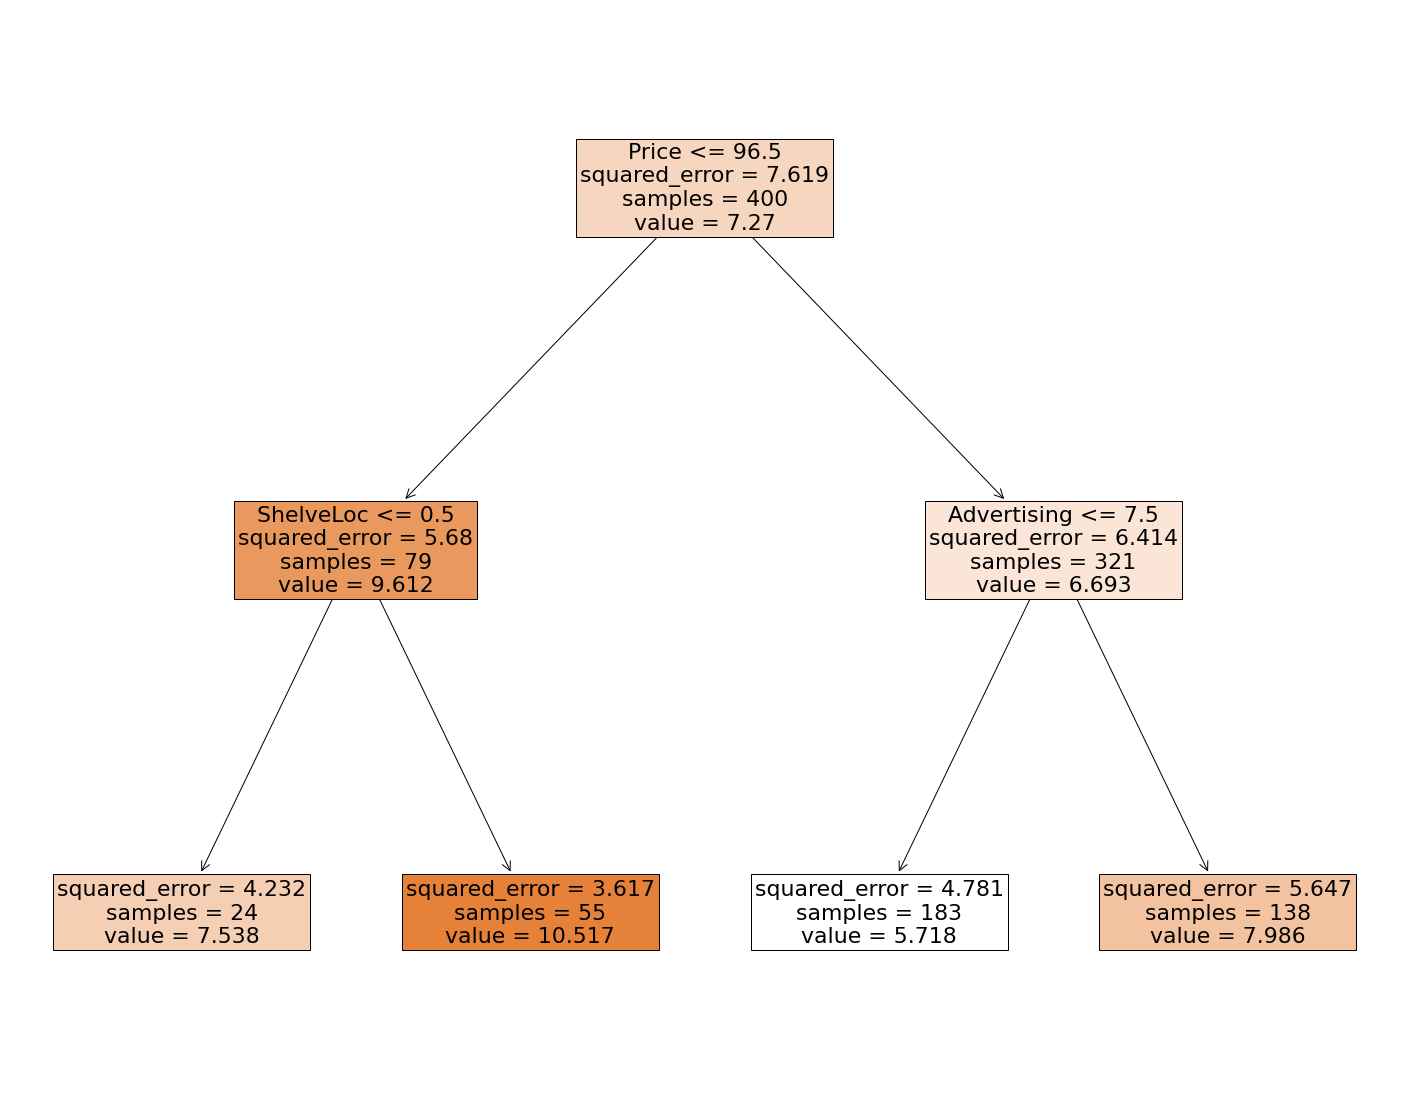

In [11]:
fig = plt.figure(figsize = (25,20))
_= tree.plot_tree(reg_tree3, feature_names = X.columns, 
               filled = True, 
              fontsize = 22)

&#9989; **<font color=red>Do this:</font>** Predict the `Sales` value for the first data point in the carseats data set using each of the three trees just generated. What is the average value of the three numbers? This is the bagged prediction for this input data. 

In [12]:
X.head().iloc[0,:]

CompPrice      138
Income          73
Advertising     11
Population     276
Price          120
ShelveLoc        0
Age             42
Education       17
Urban            1
US               1
Name: 0, dtype: int64

In [13]:
# Your code to get the bagged prediction for the first here.
(6.179 + 4.737 + 7.986)/3

6.300666666666667


![Stop Icon](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Vienna_Convention_road_sign_B2a.svg/180px-Vienna_Convention_road_sign_B2a.svg.png)

Great, you got to here! Hang out for a bit, there's more lecture before we go on to the next portion. 

# Random Forests

Did you really need to do all that bagging by hand? Well, no actually, but this goes under the "eating your vegetables exactly once" part of the lab. Of course, `sklearn` has built in functions to do bagging for us. In reality, it just has a random forest function, but if we really want to do bagging, we can cheat. 

Remember, for random forests, we essentially do bagging but we only allow for a subset of $m \leq p$ variables to be considered at each splitting step. So if we want bagging, we set the $m=$`max_features` to be the total number of features. That means this next code actually replecates what we just did above with bagging. 

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
# Note we have p=10 input variables
print(X.shape)

(400, 10)


In [16]:
bagged_carseats = RandomForestRegressor(max_features = 10, oob_score = True )
bagged_carseats.fit(X,y)


RandomForestRegressor(max_features=10, oob_score=True)

&#9989; **<font color=red>Do this:</font>** Build a random forest model instead where the maximum number of features used at each step is $m = \sqrt {p}$. 

In [20]:
# Your code here #
p = 10
m = int(np.sqrt(p))
rf = RandomForestRegressor(max_features = m, oob_score = True)
rf.fit(X,y)

RandomForestRegressor(max_features=3, oob_score=True)

Because we have that `oob_score = True` set, we get access to the out of bag predictions (i.e., $\hat y$) from `forest_carseats.oob_prediction_`. That is, for each data point, predict its $\hat y$ by returning the averaged value using only the trees it wasn't involved in fitting.

&#9989; **<font color=red>Do this:</font>** Determine the OOB error on the forest model you built just above using the `mean_squared_error` command. 

*Note:* The class does also keep track of the oob score as `model.oob_score_`, however this appears to be reporting $R^2$ (where close to 1 is better) and I don't seem to have the ability to change this.  See [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for further details. 

In [25]:
# Your code here
mean_squared_error(rf.oob_prediction_,y)

2.8830709399378485

&#9989; **<font color=red>Do this:</font>** How does the number of trees used (`n_estimators` in this code) affect the error? Generate a plot like Fig 8.10 in the book for our `carseats` data. How many trees should we use? 

In [30]:
# Modify the code below to fit a bunch of models and keep track of the MSE.
p = 10

m_list = [int(np.sqrt(p)), int(p/2), int(p)]
print('m_list:', m_list)

n_tree_list = np.arange(10,201,10)

Errors = []
for m in m_list:
    M_error = []
    for i in range(len(n_tree_list)):
        n_trees = n_tree_list[i]
        
        #--------------------------------------------------
        # Add code here to train a random forest model with 
        # max_features = m, n_estimators = n_trees,
        # and the MSE saved as the error below.
        model = RandomForestRegressor(max_features = m, n_estimators = n_trees, oob_score = True)
        model.fit(X,y)
        
        error = mean_squared_error(model.oob_prediction_,y) # <----- your error goes here.
        
        
        #--------------------------------------------------
        
        M_error.append(error)
    Errors.append(np.array(M_error))


m_list: [3, 5, 10]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Text(0.5, 1.0, 'Error in random forest for different values of $m$')

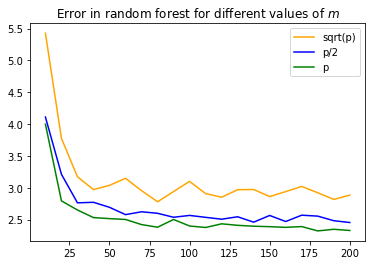

In [31]:
# If your code above works, below you'll get a plot of the different choices of m
colors = ['orange','blue','green']
labels = ['sqrt(p)', 'p/2', 'p']

for i in range(3):
    M_error = Errors[i]
    plt.plot(n_tree_list, M_error, label = labels[i], color = colors[i])

plt.legend()
plt.title('Error in random forest for different values of $m$')



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.